# inference 코드

In [14]:
import pandas as pd
import re

def extract_metrics(text):
    data = []
    current_model = ""
    current_init_seq = ""
    
    for line in text.split('\n'):
        if line.startswith("Running test for model:"):
            current_model = line.split(":")[1].strip().split(",")[0]
            current_init_seq = line.split("init_seq:")[1].strip()
        
        # Position 별 메트릭 추출
        match = re.match(r"Position (\d+) - MAE: ([\d.]+), RMSE: ([\d.]+), Non-zero MAE: ([\d.]+), Non-zero RMSE: ([\d.]+), Intent Accuracy: ([\d.]+)", line)
        
        if match:
            position, mae, rmse, nz_mae, nz_rmse, intent_acc = match.groups()
            data.append({
                'Model': current_model,
                'Init_Seq': current_init_seq,
                'Position': int(position),
                'MAE': float(mae),
                'RMSE': float(rmse),
                'Non-zero MAE': float(nz_mae),
                'Non-zero RMSE': float(nz_rmse),
                'Intent Accuracy': float(intent_acc)
            })
    
    return pd.DataFrame(data)

# 텍스트 데이터를 변수에 저장 (여기서는 'text' 변수에 저장되었다고 가정)
# Reload the data and apply the corrected extraction logic
file_path = "./inference_results.txt"
with open(file_path, 'r') as file:
    file_content = file.read()

# 데이터프레임 생성
df = extract_metrics(file_content)

# 결과 확인
print(df)

        Model Init_Seq  Position      MAE     RMSE  Non-zero MAE  \
0         rnn        1         1  51.4567  71.5805      117.8528   
1         rnn        1         2  55.1623  77.1409      117.3386   
2         rnn        1         3  58.0939  83.4769      115.0078   
3         rnn        1         4  61.0195  89.6989      113.1025   
4         rnn        1         5  62.8019  92.0473      115.5188   
..        ...      ...       ...      ...      ...           ...   
655  tabllama        4        25   9.0178  13.3254       14.0593   
656  tabllama        4        26   8.9915  13.4601       13.8247   
657  tabllama        4        27   8.8720  13.3700       13.2214   
658  tabllama        4        28   8.8621  13.5184       13.0214   
659  tabllama        4        29   8.8881  13.5174       13.2066   

     Non-zero RMSE  Intent Accuracy  
0         161.0064           0.7381  
1         159.0940           0.7143  
2         151.3671           0.5238  
3         146.7875           0.

/tmp/ipykernel_2091025/2230744618.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(models)))


Model rnn in Init_Seq 1 exceeded threshold at positions: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29
Model rnn in Init_Seq 2 exceeded threshold at positions: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29
Model rnn in Init_Seq 3 exceeded threshold at positions: 3, 4


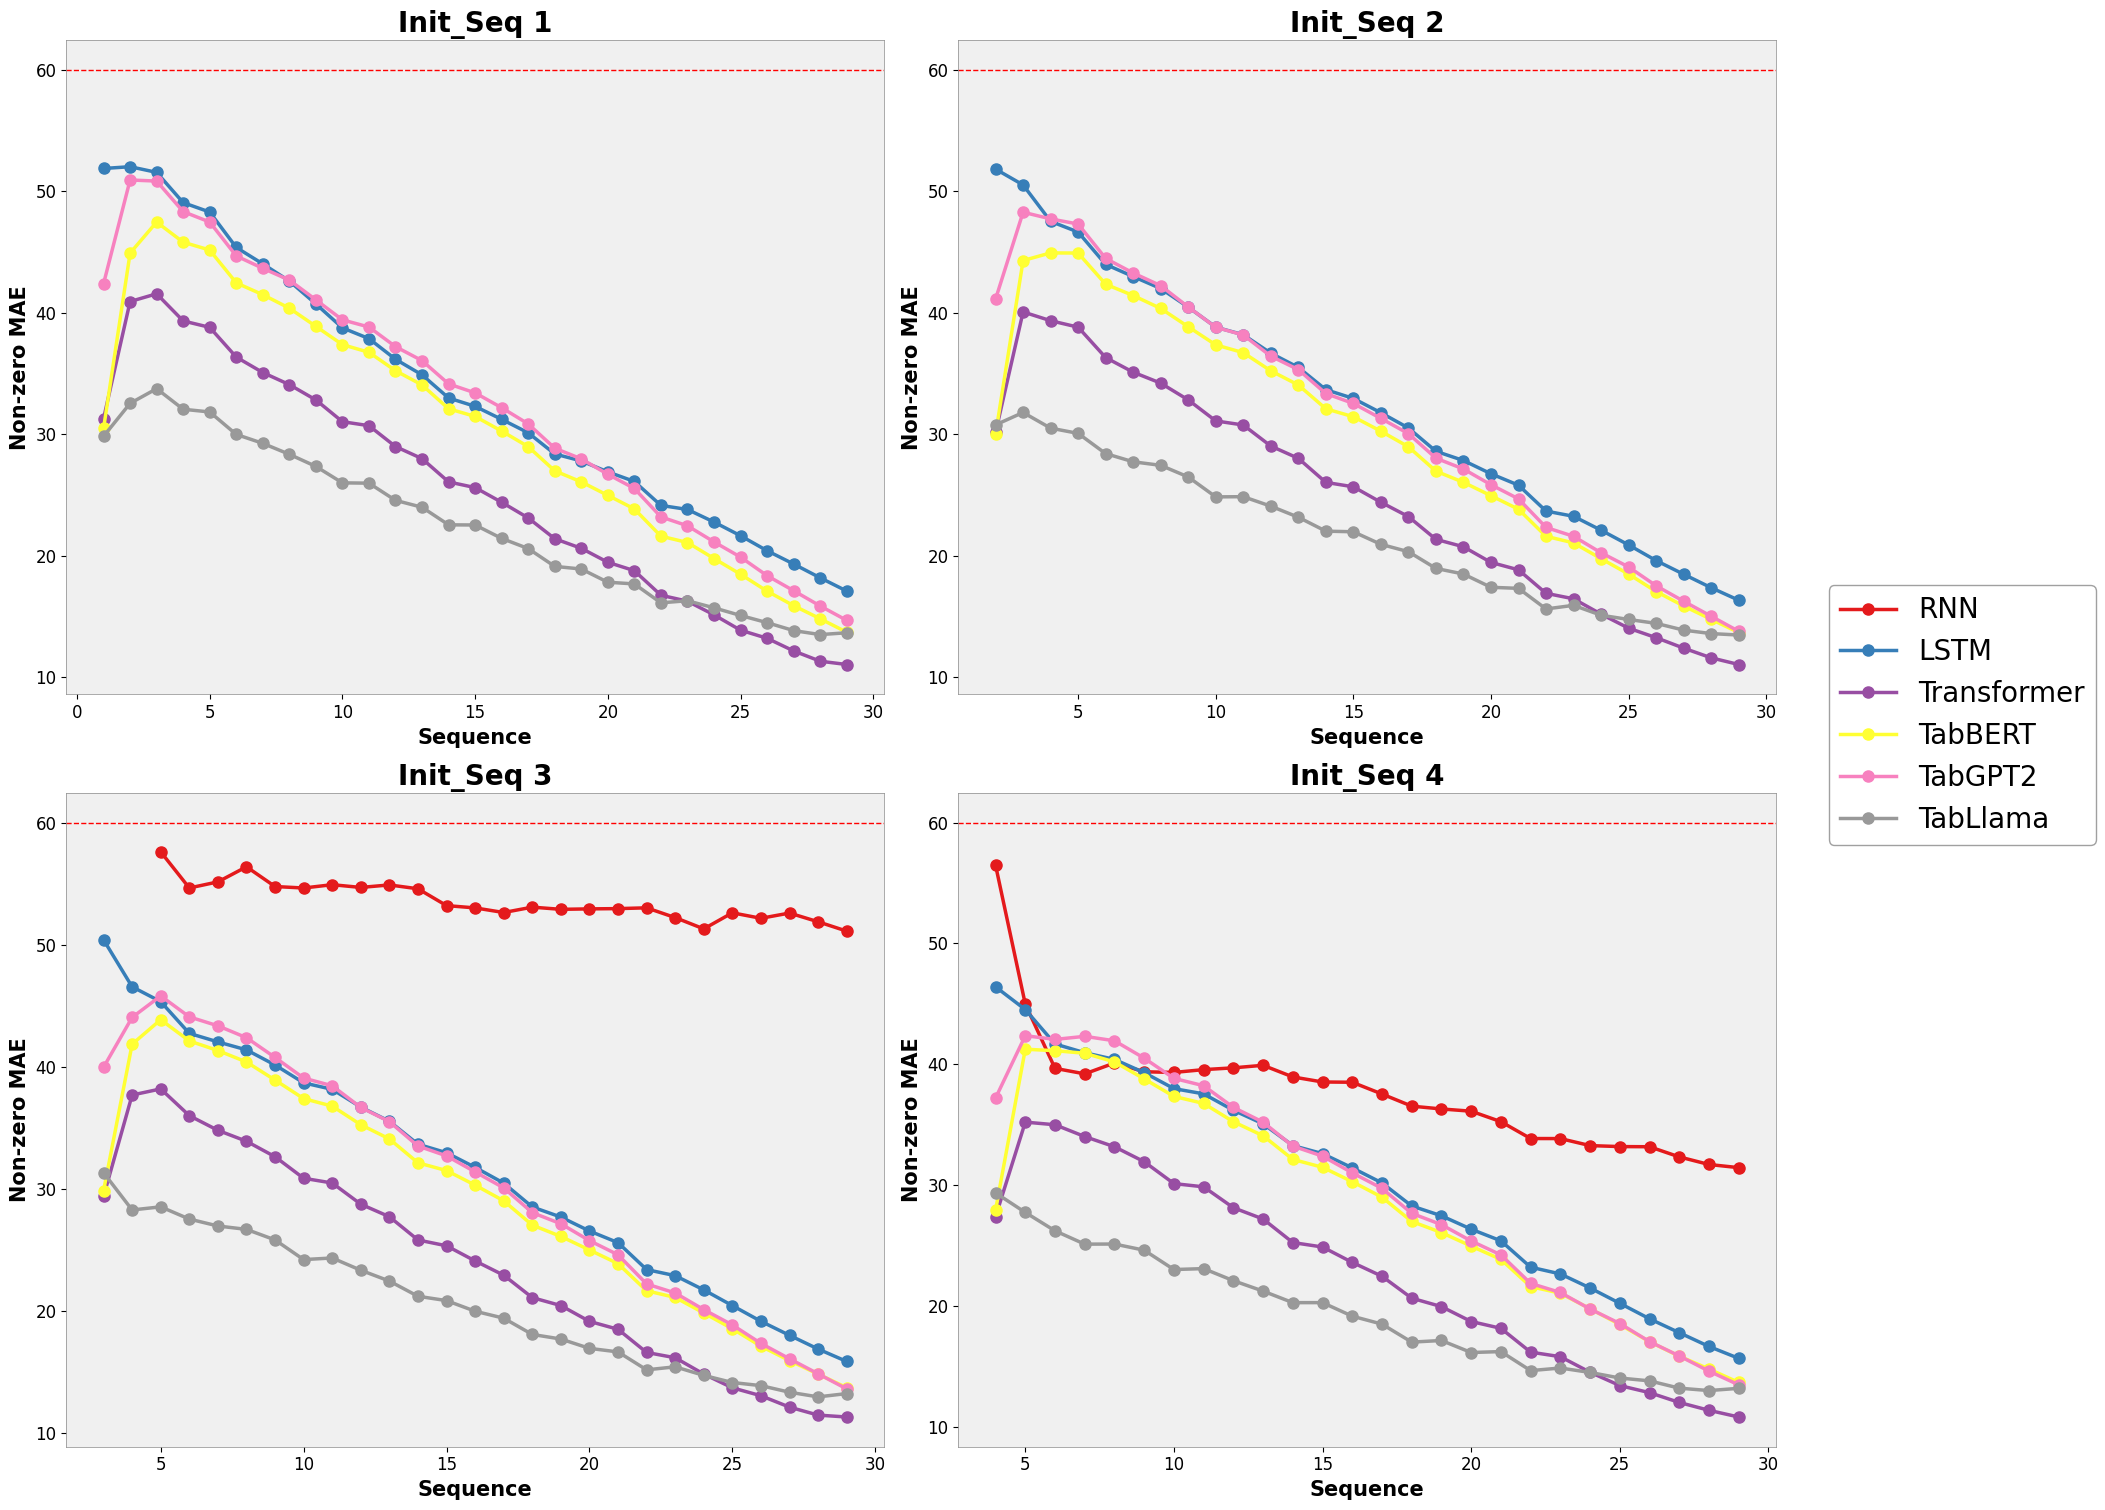

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def compare_all_models_performance_grid(df, metric, threshold=float('inf')):
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))

    models = ['rnn', 'lstm', 'vanillatf', 'tabbert', 'tabgpt2', 'tabllama']
    colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, len(models)))

    for idx, init_seq in enumerate([1, 2, 3, 4]):
        row = idx // 2
        col = idx % 2
        ax = axs[row, col]

        df_filtered = df[df['Init_Seq'] == str(init_seq)]

        for model_idx, model_name in enumerate(models):
            model_data = df_filtered[df_filtered['Model'] == model_name]

            if not model_data.empty:
                model_data = model_data.sort_values('Position')
                positions = model_data['Position'].values
                values = model_data[metric].values
                
                formatted_name = model_name.replace('tab', 'Tab').replace('lstm', 'LSTM').replace('vanillatf', 'Transformer').replace('gpt', 'GPT').replace('bert', 'BERT').replace('llama', 'Llama').replace('rnn', 'RNN')
                
                # threshold를 기준으로 그릴 구간 찾기
                draw_ranges = []
                start = 0
                for i, v in enumerate(values):
                    if v > threshold and start is not None:
                        draw_ranges.append((start, i))
                        start = None
                    elif v <= threshold and start is None:
                        start = i
                if start is not None:
                    draw_ranges.append((start, len(values)))
                
                # 각 구간 그리기
                for start, end in draw_ranges:
                    ax.plot(positions[start:end], values[start:end], marker='o', markersize=8, linewidth=2.5, label=formatted_name if start == 0 else "", color=colors[model_idx])
                
                # threshold 초과 지점 출력
                threshold_exceeded = [i for i, v in enumerate(values) if v > threshold]
                if threshold_exceeded:
                    print(f"Model {model_name} in Init_Seq {init_seq} exceeded threshold at positions: {', '.join(map(str, positions[threshold_exceeded]))}")
            else:
                print(f"No data available for model: {model_name} in Init_Seq {init_seq}")

        ax.set_title(f'Init_Seq {init_seq}', fontsize=20, fontweight='bold')
        ax.set_xlabel('Sequence', fontsize=15, fontweight='bold')
        ax.set_ylabel(metric, fontsize=15, fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        ax.grid(False)
        ax.set_facecolor('#f0f0f0')
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('#888888')
            spine.set_linewidth(0.5)

        # 임계값 선 그리기
        ax.axhline(y=threshold, color='r', linestyle='--', linewidth=1)

    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.91, 0.5), fontsize=20, frameon=True, facecolor='white', edgecolor='#888888')

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

# 사용 예시
compare_all_models_performance_grid(df, 'Non-zero MAE', threshold=60)  # 임계값 60 설정

# intent 성능표

In [5]:
import pandas as pd
import re

# Read the file
with open('./intent_results.txt', 'r', encoding='utf-8') as file:
    data = file.read()

# Regex pattern to capture the model name and intent metrics
model_pattern = r'Running test for model: (\w+)'
intent_pattern = r'Intent: intent_(\d+)\s+mae: ([\d.]+)\s+rmse: ([\d.]+)\s+non_zero_mae: ([\d.]+)\s+non_zero_rmse: ([\d.]+)\s+precision: ([\d.]+)\s+recall: ([\d.]+)\s+f1_score: ([\d.]+)\s+support: ([\d.]+)'

# Extract model names and intent metrics
models = re.findall(model_pattern, data)
matches = re.findall(intent_pattern, data)

# Define column names
columns = ['Model', 'Intent', 'MAE', 'RMSE', 'Non-zero MAE', 'Non-zero RMSE', 'Precision', 'Recall', 'F1 Score', 'Support']

# Create a list of dictionaries for each intent
intent_data = []
current_model = None
model_index = 1

for match in matches:
    if model_index < len(models):
        current_model = models[model_index]
    
    intent_data.append({
        'Model': current_model,
        'Intent': int(match[0])+1,
        'MAE': float(match[1]),
        'RMSE': float(match[2]),
        'Non-zero MAE': float(match[3]),
        'Non-zero RMSE': float(match[4]),
        'Precision': float(match[5]),
        'Recall': float(match[6]),
        'F1 Score': float(match[7]),
        'Support': float(match[8])
    })
    
    # Increment model index for next model after each intent group
    if len(intent_data) % 7 == 0:  # assuming each model has 7 intents
        model_index += 1

# Create DataFrame
df = pd.DataFrame(intent_data, columns=columns)

# Recall 이 바로 Intent별 ACC입니다.

In [6]:
df[df['Intent']==1][['Model','MAE','RMSE','Non-zero MAE','Non-zero RMSE','Recall']]

,Model,MAE,RMSE,Non-zero MAE,Non-zero RMSE,Recall
0,lstm,6.4860,14.1669,19.8007,28.8054,1.0000
7,vanillatf,6.4866,14.3568,20.2917,29.4488,1.0000
14,tabbert,6.4262,13.1015,18.9579,26.1546,0.8939
21,tabgpt2,6.3875,12.9768,18.6085,25.7317,0.8939
28,tabllama,6.4021,13.2589,18.8159,26.1923,0.8939
35,tabllama,6.4641,13.0786,18.6527,25.8665,0.9848


In [7]:
df[df['Intent']==2][['Model','MAE','RMSE','Non-zero MAE','Non-zero RMSE','Recall']]

,Model,MAE,RMSE,Non-zero MAE,Non-zero RMSE,Recall
1,lstm,5.6170,13.1001,20.7121,29.3753,0.7073
8,vanillatf,5.5732,12.9453,20.5112,29.0760,0.7073
15,tabbert,5.7294,12.8718,19.9809,28.4349,0.7073
22,tabgpt2,6.0935,15.2795,22.0480,34.5728,0.7073
29,tabllama,5.6244,13.1613,19.8573,28.8710,0.7073
36,tabllama,5.6486,12.6915,20.0893,28.3565,0.7073


In [8]:
df[df['Intent']==3][['Model','MAE','RMSE','Non-zero MAE','Non-zero RMSE','Recall']]

,Model,MAE,RMSE,Non-zero MAE,Non-zero RMSE,Recall
2,lstm,5.4202,13.2253,19.4545,27.1371,0.7896
9,vanillatf,5.6138,13.4706,19.7961,27.9829,0.7896
16,tabbert,5.6837,13.1204,19.3289,26.7917,0.7896
23,tabgpt2,5.8513,13.6733,19.7957,27.7623,0.7896
30,tabllama,5.6347,13.4625,19.4928,27.1254,0.7896
37,tabllama,5.7680,13.0372,18.9349,26.4597,0.7896


In [9]:
df[df['Intent']==3][['Model','MAE','RMSE','Non-zero MAE','Non-zero RMSE','Recall']]

,Model,MAE,RMSE,Non-zero MAE,Non-zero RMSE,Recall
2,lstm,5.4202,13.2253,19.4545,27.1371,0.7896
9,vanillatf,5.6138,13.4706,19.7961,27.9829,0.7896
16,tabbert,5.6837,13.1204,19.3289,26.7917,0.7896
23,tabgpt2,5.8513,13.6733,19.7957,27.7623,0.7896
30,tabllama,5.6347,13.4625,19.4928,27.1254,0.7896
37,tabllama,5.7680,13.0372,18.9349,26.4597,0.7896


In [10]:
df[df['Intent']==4][['Model','MAE','RMSE','Non-zero MAE','Non-zero RMSE','Recall']]

,Model,MAE,RMSE,Non-zero MAE,Non-zero RMSE,Recall
3,lstm,6.6224,13.2074,18.1818,25.9044,0.8864
10,vanillatf,6.4817,13.1518,18.6141,26.0212,0.8864
17,tabbert,6.5208,13.0663,18.6544,25.7901,0.8864
24,tabgpt2,6.7796,13.3883,18.1989,25.7934,0.8864
31,tabllama,6.6667,13.4617,18.1689,26.0920,0.8864
38,tabllama,6.7028,13.3318,18.6633,26.2122,0.8864


In [11]:
df[df['Intent']==5][['Model','MAE','RMSE','Non-zero MAE','Non-zero RMSE','Recall']]

,Model,MAE,RMSE,Non-zero MAE,Non-zero RMSE,Recall
4,lstm,5.7338,13.6260,20.5547,29.5595,0.7809
11,vanillatf,5.9185,14.6719,21.8421,32.2361,0.7809
18,tabbert,5.8270,13.7473,21.0041,29.6246,0.7809
25,tabgpt2,5.7391,13.2606,20.2469,28.1981,0.7809
32,tabllama,5.5430,13.3773,20.3898,28.7040,0.7774
39,tabllama,5.7514,13.2238,20.1705,28.2533,0.7703


In [12]:
df[df['Intent']==6][['Model','MAE','RMSE','Non-zero MAE','Non-zero RMSE','Recall']]

,Model,MAE,RMSE,Non-zero MAE,Non-zero RMSE,Recall
5,lstm,5.9386,12.7898,18.8302,26.5283,0.8347
12,vanillatf,6.1166,13.9125,19.9999,29.3360,0.8347
19,tabbert,5.9393,12.6364,18.7394,26.1025,1.0000
26,tabgpt2,6.5106,15.1866,20.8899,32.0456,1.0000
33,tabllama,6.0327,13.1337,18.6024,26.7423,1.0000
40,tabllama,5.9851,12.6546,18.7249,26.1216,0.8347


In [13]:
df[df['Intent']==7][['Model','MAE','RMSE','Non-zero MAE','Non-zero RMSE','Recall']]

,Model,MAE,RMSE,Non-zero MAE,Non-zero RMSE,Recall
6,lstm,5.4834,13.0938,20.5396,28.4533,0.8065
13,vanillatf,5.6742,13.1360,20.3425,28.4875,0.8161
20,tabbert,5.5614,12.5478,19.8068,26.8607,0.8161
27,tabgpt2,5.5654,12.4233,19.3400,26.2697,0.8161
34,tabllama,5.5456,12.7567,19.5437,27.0718,0.8161
41,tabllama,5.5403,12.4346,19.3978,26.5900,0.8161
